Langchainを組み込む

In [1]:
!pip install openai pandas matplotlib seaborn langchain

In [2]:
!pip install langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00


In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                                    title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                                      Chocolate Sales Data 📊🍫                              63KB  2025-03-07 05:44:03           5292         70  1.0              
abdulmalik1518/mobiles-dataset-2025                                    Mobiles Dataset (2025)                               20KB  2025-02-18 06:50:24          12190        218  1.0              
willianoliveiragibin/pixar-films                                       Pixar Films                                           2KB  2025-03-07 22:43:51           1018         24  1.0              
atharvasoundankar/global-

In [4]:
!kaggle datasets download gauravkumar2525/top-rated-movies-from-tmdb

Dataset URL: https://www.kaggle.com/datasets/gauravkumar2525/top-rated-movies-from-tmdb
License(s): apache-2.0
  0% 0.00/1.35M [00:00<?, ?B/s]
100% 1.35M/1.35M [00:00<00:00, 42.7MB/s]


In [5]:
!unzip /content/top-rated-movies-from-tmdb.zip -d /content/data

Archive:  /content/top-rated-movies-from-tmdb.zip
  inflating: /content/data/top_rated_movies.csv  


In [ ]:
import openai
import pandas as pd
import os
from google.colab import files
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# OpenAI APIキー設定
openai_api_key = "APIキー"
llm = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=openai_api_key)

# ======= データの取得 =======
choice = input("データ取得方法を選択してください（1: アップロード, 2: フォルダ内のCSVを使用）: ")

if choice == "1":
    print("CSVファイルをアップロードしてください。")
    uploaded = files.upload()  # ファイルアップロード
    filename = list(uploaded.keys())[0]  # アップロードされたファイル名を取得

elif choice == "2":
    folder_path = "/content/data"  # Colab上のデータフォルダ
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    if len(csv_files) == 0:
        print("フォルダ内にCSVファイルが見つかりません。")
        filename = None
    else:
        print("フォルダ内のCSVファイル:", csv_files)
        filename = os.path.join(folder_path, csv_files[0])  # 最初のCSVを選択

else:
    print("無効な選択肢です。1 または 2 を入力してください。")
    filename = None

# ======= データの読み込み =======
if filename:
    df = pd.read_csv(filename)
    print(f"読み込んだデータ: {filename}")
    print(df.head())  # 先頭5行を表示

    # データの統計情報を取得
    data_summary = df.describe().to_string()

    # ======= AIに「このデータで何ができるか」を提案させる =======
    prompt_template_idea = PromptTemplate(
        input_variables=["data_summary"],
        template="""
        ユーザーが提供したデータを元に、このデータで何ができるかをリストアップしてください。
        具体的な分析手法ではなく、「このデータからどのような洞察が得られるか？」という視点で考えてください。

        例:
        - 顧客の購買傾向を分析する
        - 売上の増加要因を特定する
        - 社員のパフォーマンスを評価する
        - 異常値を検出し、不正を防ぐ

        データの統計情報:
        {data_summary}
        """
    )

    chain_idea = LLMChain(llm=llm, prompt=prompt_template_idea)
    idea_suggestions = chain_idea.run(data_summary=df.describe().to_string())

    print("\n=== AIの提案（このデータで何ができるか） ===\n", idea_suggestions)

    # ユーザーが選択
    user_choice = input("\n上記の提案から、実施したい項目を入力してください: ")

    # ======= AIに適切な分析手法を提示させる =======
    prompt_template_analysis = PromptTemplate(
        input_variables=["user_choice", "data_summary"],
        template="""
        ユーザーが「{user_choice}」を行いたいと考えています。
        そのために適切なデータ分析手法を複数提案してください。
        それぞれの手法について、以下を説明してください：
        - なぜこの分析手法を選ぶのか？
        - どのような情報が得られるのか？
        - どのように解釈すればよいのか？

        データの統計情報:
        {data_summary}
        """
    )

    chain_analysis = LLMChain(llm=llm, prompt=prompt_template_analysis)
    analysis_suggestions = chain_analysis.run(user_choice=user_choice, data_summary=df.describe().to_string())

    print("\n=== AIの分析提案（適切な分析手法） ===\n", analysis_suggestions)

    # ======= 提案された分析に基づきコードを生成 =======
    prompt_template_code = PromptTemplate(
        input_variables=["analysis_suggestions"],
        template="""
        ユーザーが以下のデータを分析したいと考えています。
        あなたはPythonコードを提供してください。
        提案された分析方法を基に、Pandas、Matplotlib、Seaborn、Scikit-learnを使用してデータ分析を行うPythonコードを書いてください。
        ただし、データフレーム df は既にColab上に存在しているものとして、データの読み込み部分は不要です。

        {analysis_suggestions}
        """
    )

    chain_code = LLMChain(llm=llm, prompt=prompt_template_code)
    generated_code = chain_code.run(analysis_suggestions=analysis_suggestions)

    print("\n=== AIの生成したPythonコード ===")
    print("\n👇👇👇 以下を次のセルにコピペして実行してください 👇👇👇\n")
    print(generated_code)


<ipython-input-6-9ef6f050cdf4>:11: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=openai_api_key)


データ取得方法を選択してください（1: アップロード, 2: フォルダ内のCSVを使用）: 2
フォルダ内のCSVファイル: ['top_rated_movies.csv']
読み込んだデータ: /content/data/top_rated_movies.csv
    id            original_title  \
0  278  The Shawshank Redemption   
1  238             The Godfather   
2  240     The Godfather Part II   
3  424          Schindler's List   
4  389              12 Angry Men   

                                            overview release_date  popularity  \
0  Imprisoned in the 1940s for the double murder ...   1994-09-23     134.506   
1  Spanning the years 1945 to 1955, a chronicle o...   1972-03-14     134.960   
2  In the continuing saga of the Corleone crime f...   1974-12-20      72.167   
3  The true story of how businessman Oskar Schind...   1993-12-15      70.884   
4  The defense and the prosecution have rested an...   1957-04-10      52.787   

   vote_average  vote_count  
0         8.708       27828  
1         8.689       21124  
2         8.570       12750  
3         8.567       16197  
4         8.5

<ipython-input-6-9ef6f050cdf4>:66: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain_idea = LLMChain(llm=llm, prompt=prompt_template_idea)
<ipython-input-6-9ef6f050cdf4>:67: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  idea_suggestions = chain_idea.run(data_summary=df.describe().to_string())



=== AIの提案（このデータで何ができるか） ===
 このデータを元に得られる洞察は以下の通りです。

- 映画や作品の人気度（popularity）と評価（vote_average）との関係を分析することで、どのような特性が高評価に寄与しているのかを明らかにする。
- 顧客の評価（vote_average）や投票数（vote_count）を基に、どの作品が特に支持されているのか、またその理由を探る。
- 人気の高い作品に共通する特徴（ジャンル、制作年、キャスト等）を特定することで、今後の作品制作における戦略を立てる。
- 投票数が多い作品と少ない作品の違いを分析し、マーケティング施策の改善点を見出す。
- 売上の増加要因や減少要因を、人気度や評価と関連付けて探ることで、収益向上のための施策を提案する。
- 異常な人気度や評価を持つ作品を特定し、その背景にある要因を分析することで、不正や意図的な操作を検出する。
- 時間の経過に伴う人気度や評価の変化を追跡し、トレンドや季節性を把握することで、プロモーション戦略を見直す。
- 投票数に基づいて、顧客の関心が高まっているジャンルやテーマを特定し、今後の作品開発に生かす。
- 高評価・高投票数の作品の成功要因を分析し、類似作品の制作に役立てる。
- 顧客の評価の分布を分析し、ターゲット層の特性を理解することで、マーケティング戦略を最適化する。 

これらの洞察を得ることで、データを活用した戦略的な意思決定が可能となります。

上記の提案から、実施したい項目を入力してください: 投票数に基づいて、顧客の関心が高まっているジャンルやテーマを特定し、今後の作品開発に生かす。

=== AIの分析提案（適切な分析手法） ===
 顧客の関心が高まっているジャンルやテーマを特定するために、以下のデータ分析手法を提案します。

### 1. クラスタリング分析

- **なぜこの分析手法を選ぶのか？**
  クラスタリング分析は、データを類似性に基づいてグループ化する手法です。各作品の `popularity`、`vote_average`、`vote_count`を基に、顧客の関心を示す特徴的なグループを見つけることができます。

- **どのような情報が得られるのか？**
  類似したプロパティを持つ作品のグループを特定し

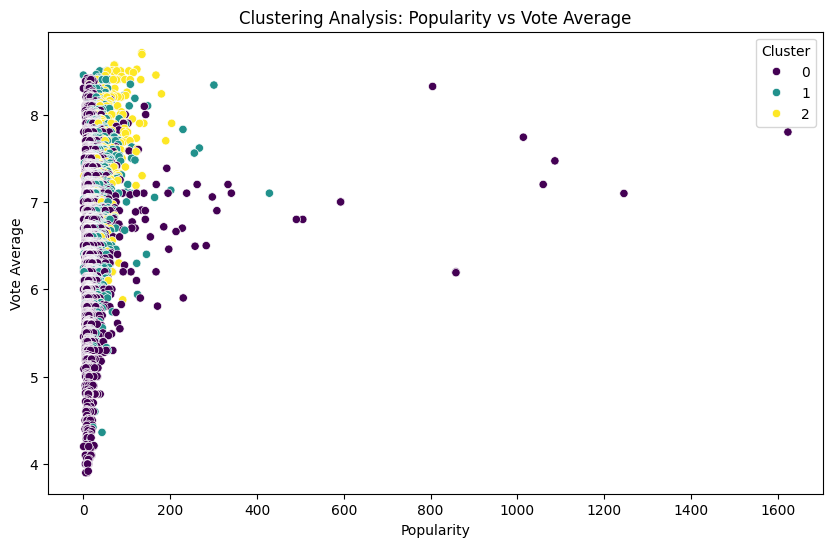

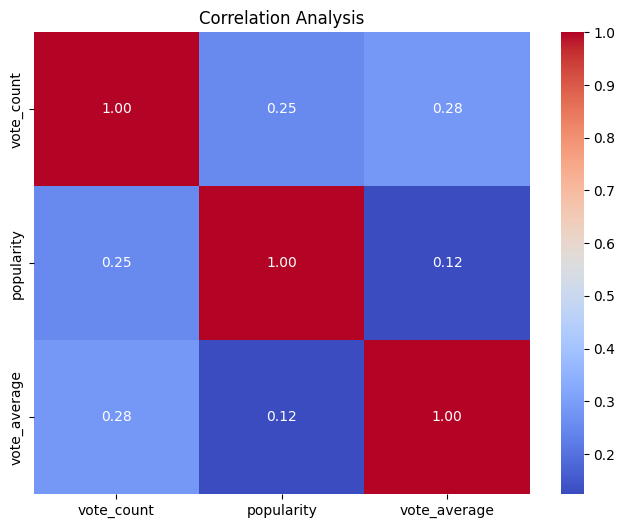

KeyError: 'release_date'

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# データフレームの確認
print(df.head())

# 1. クラスタリング分析
# 特徴量として 'popularity', 'vote_average', 'vote_count' を使用
features = df[['popularity', 'vote_average', 'vote_count']].dropna()

# KMeansクラスタリングを適用
kmeans = KMeans(n_clusters=3, random_state=42)  # クラスタ数は適宜変更
features['cluster'] = kmeans.fit_predict(features)

# クラスタリング結果の可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='popularity', y='vote_average', hue='cluster', palette='viridis')
plt.title('Clustering Analysis: Popularity vs Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.legend(title='Cluster')
plt.show()

# クラスタごとの特徴を表示
cluster_summary = features.groupby('cluster').mean()
print(cluster_summary)

# 2. 相関分析
correlation_matrix = df[['vote_count', 'popularity', 'vote_average']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Analysis')
plt.show()

# 3. 時系列分析
# 'release_date' が存在すると仮定し、日付形式に変換
df['release_date'] = pd.to_datetime(df['release_date'])
df.set_index('release_date', inplace=True)

# 月ごとの vote_count の合計を計算
monthly_votes = df['vote_count'].resample('M').sum()

plt.figure(figsize=(14, 7))
monthly_votes.plot()
plt.title('Monthly Vote Count Over Time')
plt.xlabel('Date')
plt.ylabel('Total Vote Count')
plt.grid()
plt.show()

# 4. 機械学習モデル（回帰分析）
# 特徴量とターゲットの設定
X = df[['vote_average', 'vote_count']].dropna()
y = df['popularity'].dropna()

# 同じサイズにするために、データをフィルタリング
X = X.loc[y.index]

# 線形回帰モデルをフィット
model = LinearRegression()
model.fit(X, y)

# 予測
y_pred = model.predict(X)

# モデルの精度を評価
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# 回帰分析の結果を可視化
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Regression Analysis: Actual vs Predicted Popularity')
plt.show()

# 回帰係数の表示
print('Coefficients:', model.coef_)

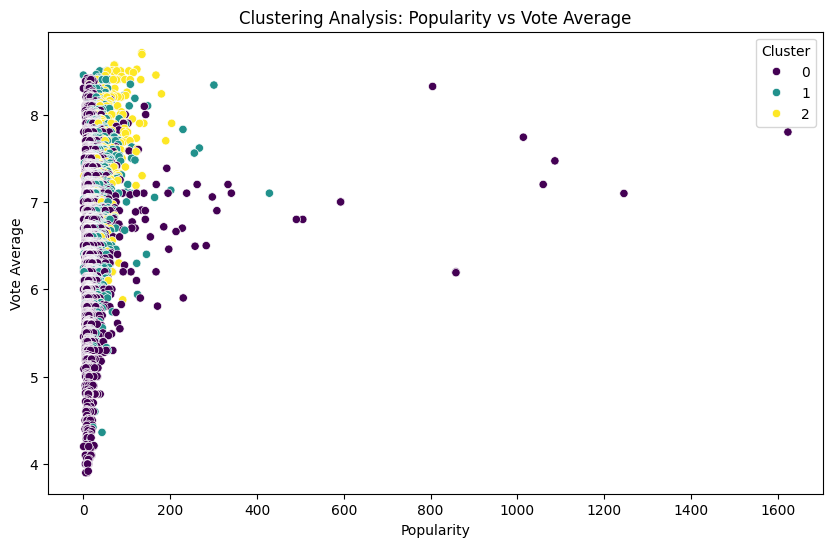

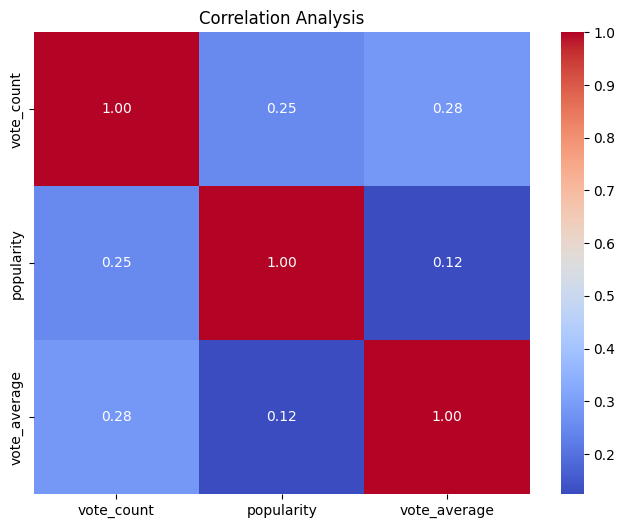

In [10]:
import re
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# ======= コードブロックのみを抽出 =======
def extract_python_code(text):
    """MarkdownのコードブロックからPythonコードのみを抽出"""
    match = re.search(r"```python(.*?)```", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return text.strip()  # もしコードブロックがなければ、元のテキストを返す

# コード部分のみ抽出
clean_code = extract_python_code(generated_code)

# ======= 生成したコードを実行 & エラーキャッチ =======
error_occurred = False  # エラー発生フラグを初期化
execution_output = ""  # 出力内容の初期化

try:
    print("\n=== AIが生成したコードを実行します ===\n")

    # 実行結果をキャプチャ
    import io
    import sys
    output_capture = io.StringIO()
    sys.stdout = output_capture  # 標準出力をキャプチャ

    exec(clean_code)  # 生成コードを実行

    # 標準出力を戻し、キャプチャした出力を取得
    sys.stdout = sys.__stdout__
    execution_output = output_capture.getvalue().strip()

except Exception as e:
    sys.stdout = sys.__stdout__
    error_message = str(e)
    error_occurred = True
    print("\n=== エラーが発生しました ===\n", error_message)

# ======= エラーが発生した場合、修正コードをAIに依頼 =======
if error_occurred:
    print("\n=== AIがエラーを修正します... ===\n")

    prompt_template_fix = PromptTemplate(
        input_variables=["clean_code", "error_message"],
        template="""
        ユーザーが以下のPythonコードを実行したところ、エラーが発生しました。
        エラーの原因を分析し、修正したPythonコードを提供してください。

        ### 元のコード:
        ```python
        {clean_code}
        ```

        ### 発生したエラー:
        {error_message}

        修正後のコードを **実行可能な形で** 提供してください。
        """
    )

    chain_fix = LLMChain(llm=llm, prompt=prompt_template_fix)
    fixed_code = chain_fix.run(clean_code=clean_code, error_message=error_message)

    # 修正されたコード部分のみ抽出
    fixed_clean_code = extract_python_code(fixed_code)

    print("\n=== AIが修正したPythonコード ===")
    print("\n👇👇👇 以下を次のセルにコピペして実行してください 👇👇👇\n")
    print(fixed_clean_code)
else:
    print("\n=== 実行成功！AIの考察を表示します ===\n")  # 確実に表示されるはず

    # ======= AIに「出力結果を解析し、それに基づいた考察」を依頼 =======
    if not execution_output:
        execution_output = "出力結果なし（コードがグラフやファイル出力のみかもしれません）"

    # 出力が長すぎる場合は先頭部分のみ送信
    if len(execution_output) > 2000:
        execution_output = execution_output[:2000] + "\n（出力が長すぎるため、一部のみ表示）"

    print("\n=== AIに考察を依頼します（デバッグ用） ===\n")
    print(f"実行結果:\n{execution_output}")

    prompt_template_interpretation = PromptTemplate(
        input_variables=["analysis_suggestion", "clean_code", "execution_output"],
        template="""
        以下のデータについて、AIが選択した分析手法を使いました。
        実際の出力結果を基に、より具体的な考察を行ってください。

        1. 実際の出力からどのような洞察が得られるのか？
        2. どのように解釈すればよいのか？
        3. もし追加の分析をするなら、どのようなアプローチが考えられるか？

        ### 実行したコード:
        ```python
        {clean_code}
        ```

        ### 実際の出力:
        {execution_output}
        """
    )

    chain_interpretation = LLMChain(llm=llm, prompt=prompt_template_interpretation)

    # analysis_suggestion が None の場合の対応
    if analysis_suggestion is None:
        analysis_suggestion = "分析手法が特定されていません"

    interpretation = chain_interpretation.run(
        analysis_suggestion=analysis_suggestion,
        clean_code=clean_code,
        execution_output=execution_output
    )

    print("\n=== AIの出力結果に基づく考察 ===\n")
    print(interpretation)
